# Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
from copy import deepcopy
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model

In [ ]:
def coreset(x_coresets, y_coresets, x_train, y_train, size, mode='random'):
  if mode == 'centre':
    indices = [0]
    current = 0
    dists = np.full(len(x_train), np.inf)
    for i in range(1, size):
      dists = np.minimum([np.linalg.norm(x_train[j] - x_train[current]) for j in range(len(x_train))], dists)
      current = np.argmax(dists)
      indices.append(current)
  else:
    indices = np.random.choice(len(x_train), size=size, replace=False)
  x_coresets.append(x_train[indices])
  y_coresets.append(y_train[indices])
  x_train = np.delete(x_train, indices, axis = 0)
  y_train = np.delete(y_train, indices, axis = 0)
  return x_coresets, y_coresets, x_train, y_train

In [ ]:
class MFVI(nn.Module):
  def __init__(self, input_dim, layers, heads, output_dim, head, prior = None):
    super(MFVI, self).__init__()
    self.input_dim = input_dim
    self.layers = layers
    self.heads = heads
    self.output_dims = []

    self.prior = None
    self.prior_head = None
    self.posterior = None
    self.posterior_head = None
    self._init_weights(prior, head, output_dim)

  def forward(self, x, head):
    sampled_layers = []
    (w_means, w_logvars, b_means, b_logvars) = self.posterior
    for i in range(len(w_means)):
      w_epsilon = torch.randn_like(w_means[i])
      b_epsilon = torch.randn_like(b_means[i])
      sampled_layers.append((w_means[i] + w_epsilon * torch.exp(0.5*w_logvars[i]), b_means[i] + b_epsilon * torch.exp(0.5*b_logvars[i])))
    (w_means, w_logvars, b_means, b_logvars) = self.posterior_head
    i = 0
    while i < len(w_means[head])-1:
      w_epsilon = torch.randn_like(w_means[head][i])
      b_epsilon = torch.randn_like(b_means[head][i])
      sampled_layers.append((w_means[head][i] + w_epsilon * torch.exp(0.5*w_logvars[head][i]), b_means[head][i] + b_epsilon * torch.exp(0.5*b_logvars[head][i])))
      i += 1
    for layer in sampled_layers:
      x = torch.relu(x @ layer[0] + layer[1])
    w_epsilon = torch.randn_like(w_means[head][i])
    b_epsilon = torch.randn_like(b_means[head][i])
    x = x @ (w_means[head][i] + w_epsilon * torch.exp(0.5*w_logvars[head][i])) + (b_means[head][i] + b_epsilon * torch.exp(0.5*b_logvars[head][i]))
    return x

  def predict(self, x, head, num_samples = 100):
    outputs = torch.empty(num_samples, len(x), self.output_dims[head])
    for i in range(num_samples):
      outputs[i] = nn.Softmax(dim = 1)(self.forward(x, head))
    outputs = outputs.mean(dim = 0)
    return outputs

  def mle_loss(self, x, y, head):
    for i in range(len(self.posterior[0])):
      x = torch.relu(x @ self.posterior[0][i] + self.posterior[2][i])
    i = 0
    while i < len(self.posterior_head[0][head])-1:
      x = torch.relu(x @ self.posterior_head[0][head][i] + self.posterior_head[2][head][i])
      i += 1
    x = x @ self.posterior_head[0][head][i] + self.posterior_head[2][head][i]
    return nn.CrossEntropyLoss()(x, y)

  def kl_loss(self, x, y, head, size = 60000, samples = 10):
    kl = self.kl(head) / size
    log_likelihood = self.log_likelihood(x, y, head, samples)
    #print(kl, log_likelihood)
    return kl - log_likelihood

  def kl(self, head):
    prior_means = torch.cat([torch.flatten(x).to(device) for x in self.prior[0] + self.prior[2] + [elem for sublist in self.prior_head[0] for elem in sublist] + [elem for sublist in self.prior_head[2] for elem in sublist]])
    prior_logvars = torch.cat([torch.flatten(x).to(device) for x in self.prior[1] + self.prior[3] + [elem for sublist in self.prior_head[1] for elem in sublist] + [elem for sublist in self.prior_head[3] for elem in sublist]])
    prior_vars = torch.exp(prior_logvars)
    posterior_means = torch.cat([torch.flatten(x).to(device) for x in self.posterior[0] + self.posterior[2] + [elem for sublist in self.posterior_head[0] for elem in sublist] + [elem for sublist in self.posterior_head[2] for elem in sublist]])
    posterior_logvars = torch.cat([torch.flatten(x).to(device) for x in self.posterior[1] + self.posterior[3] + [elem for sublist in self.posterior_head[1] for elem in sublist] + [elem for sublist in self.posterior_head[3] for elem in sublist]])
    posterior_vars = torch.exp(posterior_logvars)
    kl_normal = prior_logvars - posterior_logvars + (posterior_vars + torch.pow(posterior_means - prior_means, 2)) / (prior_vars + 1e-8) - 1
    return torch.sum(kl_normal) * 0.5

  def log_likelihood(self, x, y, head, samples):
    outputs = []
    for i in range(samples):
      outputs.append(self.forward(x, head))
    outputs = torch.cat(outputs)
    return - nn.CrossEntropyLoss()(outputs, y.repeat(samples).view(-1))

  def _init_weights(self, prior, head, output_dim):
    parameter_mean = lambda x: nn.Parameter(torch.randn_like(x, requires_grad=True)*0.1)
    parameter_var = lambda x: nn.Parameter(torch.ones_like(x, requires_grad=True)*-6*math.log(10))

    if prior is not None:
      self.output_dims = [x[-1].shape[0] for x in prior[1][2]]
      self.prior = deepcopy(prior[0])
      self.prior_head = deepcopy(prior[1])
      self.posterior = deepcopy(prior[0])
      self.posterior_head = deepcopy(prior[1])

      if head == len(self.output_dims):
        self.output_dims.append(output_dim)
        head_params = [self.layers[-1]] + self.heads + [output_dim]

        head_w_means = [torch.zeros(head_params[i], head_params[i+1]) for i in range(len(head_params)-1)]
        head_w_logvars = [torch.zeros_like(head_w) for head_w in head_w_means]
        head_b_means = [torch.zeros(head_params[i]) for i in range(1, len(head_params))]
        head_b_logvars = [torch.zeros_like(head_b) for head_b in head_b_means]
        self.prior_head[0].append(head_w_means)
        self.prior_head[1].append(head_w_logvars)
        self.prior_head[2].append(head_b_means)
        self.prior_head[3].append(head_b_logvars)

        head_w_means = [parameter_mean(head_w) for head_w in head_w_means]
        head_w_logvars = [parameter_var(head_w) for head_w in head_w_logvars]
        head_b_means = [parameter_mean(head_b) for head_b in head_b_means]
        head_b_logvars = [parameter_var(head_b) for head_b in head_b_logvars]
        self.posterior_head[0].append(head_w_means)
        self.posterior_head[1].append(head_w_logvars)
        self.posterior_head[2].append(head_b_means)
        self.posterior_head[3].append(head_b_logvars)

      elif head < 0 or head > len(self.prior_head[0]) + 1:
        raise Exception('Invalid head')

    else:
      self.output_dims.append(output_dim)
      w_means = [torch.zeros(self.input_dim, self.layers[0])] + [torch.zeros(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)]
      w_logvars = [torch.zeros_like(w) for w in w_means]
      b_means = [torch.zeros(self.layers[i]) for i in range(len(self.layers))]
      b_logvars = [torch.zeros_like(b) for b in b_means]
      self.prior = (w_means, w_logvars, b_means, b_logvars)

      head_params = [self.layers[-1]] + self.heads + [output_dim]
      head_w_means = [[torch.zeros(head_params[i], head_params[i+1]) for i in range(len(head_params)-1)]]
      head_w_logvars = [[torch.zeros_like(head_w) for head_w in head] for head in head_w_means]
      head_b_means = [[torch.zeros(head_params[i]) for i in range(1, len(head_params))]]
      head_b_logvars = [[torch.zeros_like(head_b) for head_b in head] for head in head_b_means]
      self.prior_head = (head_w_means, head_w_logvars, head_b_means, head_b_logvars)

      w_means = [parameter_mean(w) for w in self.prior[0]]
      w_logvars = [parameter_var(w) for w in self.prior[1]]
      b_means = [parameter_mean(b) for b in self.prior[2]]
      b_logvars = [parameter_var(b) for b in self.prior[3]]
      self.posterior = (w_means, w_logvars, b_means, b_logvars)

      head_w_means = [[parameter_mean(head_w) for head_w in head] for head in self.prior_head[0]]
      head_w_logvars = [[parameter_var(head_w) for head_w in head] for head in self.prior_head[1]]
      head_b_means = [[parameter_mean(head_b) for head_b in head] for head in self.prior_head[2]]
      head_b_logvars = [[parameter_var(head_b) for head_b in head] for head in self.prior_head[3]]
      self.posterior_head = (head_w_means, head_w_logvars, head_b_means, head_b_logvars)

    for i in range(len(self.prior[0])):
      self.register_buffer(f'w_means_{i}', self.prior[0][i])
      self.register_buffer(f'w_logvars_{i}', self.prior[1][i])
      self.register_buffer(f'b_means_{i}', self.prior[2][i])
      self.register_buffer(f'b_logvars_{i}', self.prior[3][i])

    for i in range(len(self.prior_head[0])):
      for j in range(len(self.prior_head[0][i])):
        self.register_buffer(f'head_w_means_{i}_{j}', self.prior_head[0][i][j])
        self.register_buffer(f'head_w_logvars_{i}_{j}', self.prior_head[1][i][j])
        self.register_buffer(f'head_b_means_{i}_{j}', self.prior_head[2][i][j])
        self.register_buffer(f'head_b_logvars_{i}_{j}', self.prior_head[3][i][j])

    for i in range(len(self.posterior[0])):
      self.register_parameter(f'post_w_means_{i}', self.posterior[0][i])
      self.register_parameter(f'post_w_logvars_{i}', self.posterior[1][i])
      self.register_parameter(f'post_b_means_{i}', self.posterior[2][i])
      self.register_parameter(f'post_b_logvars_{i}', self.posterior[3][i])

    for i in range(len(self.posterior_head[0])):
      for j in range(len(self.posterior_head[0][i])):
        self.register_parameter(f'post_head_w_means_{i}_{j}', self.posterior_head[0][i][j])
        self.register_parameter(f'post_head_w_logvars_{i}_{j}', self.posterior_head[1][i][j])
        self.register_parameter(f'post_head_b_means_{i}_{j}', self.posterior_head[2][i][j])
        self.register_parameter(f'post_head_b_logvars_{i}_{j}', self.posterior_head[3][i][j])

# Train and test

In [ ]:
from torch.utils.data import Dataset, DataLoader
class numpy_dataset(Dataset):  # Inherit from Dataset class
    def __init__(self, data, target):
        ## Add code here
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
def train_model(model, x_train, y_train, loss_fn, head, lr=1e-3, epochs=100, batch_size=256):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_dataset = numpy_dataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    progress = tqdm(range(epochs), 'Epochs: ')
    for epoch in progress:
        correct = 0
        total = 0
        for batch_idx, (x_data, y_data) in enumerate(train_loader):
          x_data, y_data = x_data.to(device), y_data.to(device)
          optimizer.zero_grad()
          loss = loss_fn(x_data, y_data, head)
          loss.backward()
          optimizer.step()

          y_pred = model(x_data, head)
          _, predicted = torch.max(y_pred.data, 1)
          total += y_data.size(0)
          correct += (predicted == y_data).sum().item()

        progress.set_postfix_str(f'Loss: {loss.item():.4f}, Acc: {correct/total:.4f}')
    return model

In [ ]:
def coreset_train_model(model, x_coresets, y_coresets, loss_fn, single_head, lr=1e-3, epochs=100, batch_size=256):
    if len(x_coresets) == 0:
      return model
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_datasets = [numpy_dataset(x_coresets[i], y_coresets[i]) for i in range(len(x_coresets))]
    train_loaders = [DataLoader(train_dataset, batch_size=batch_size, shuffle = True) for train_dataset in train_datasets]
    tasks = [i for i in range(len(x_coresets))]
    progress = tqdm(range(epochs), 'Epochs: ')
    for epoch in progress:
        random.shuffle(tasks)
        correct = 0
        total = 0
        for task in tasks:
          train_loader = train_loaders[task]
          head = 0 if single_head else task
          for batch_idx, (x_data, y_data) in enumerate(train_loader):
            x_data, y_data = x_data.to(device), y_data.to(device)
            optimizer.zero_grad()
            loss = loss_fn(x_data, y_data, head, len(x_coresets[task]))
            loss.backward()
            optimizer.step()

            y_pred = model(x_data, head)
            _, predicted = torch.max(y_pred.data, 1)
            total += y_data.size(0)
            correct += (predicted == y_data).sum().item()

        progress.set_postfix_str(f'Loss: {loss.item():.4f}, Acc: {correct/total:.4f}')
    return model

In [ ]:
def test_model(model, test_data, head, x_core, y_core, l = "cat"):
  model.eval()
  correct = 0
  total = 0
  test = numpy_dataset(test_data[0], test_data[1])
  test_loader = DataLoader(test, batch_size=len(test_data[0]))
  with torch.no_grad():
    for batch_idx, (x_data, y_data) in enumerate(test_loader):
      x_data, y_data = x_data.to(device), y_data.to(device)
      y_pred = model.predict(x_data, head).to(device)
      _, predicted = torch.max(y_pred.data, 1)
      if l == "cat":
        loss = torch.sqrt(nn.MSELoss()(y_pred, F.one_hot(y_data)))
        correct += (predicted == y_data).sum().item()
      else:
        loss = torch.sqrt(nn.MSELoss()(y_pred, y_data))
        correct += (predicted == y_data).sum().item()
      total += y_data.size(0)

  return correct, total, loss.item()

# VCL

In [ ]:
def vcl(layers, heads, epochs, data, mode, size, batch_size, single_head):
  in_dim, out_dim = data.get_dims()
  x_coresets = []
  y_coresets = []
  accuracy = []
  test_sets = []
  model = MFVI(in_dim, layers, heads, out_dim, 0).to(device)
  for i in range(data.max_iter):
    print(f'Task {i + 1}')
    x_train, y_train, x_test, y_test = data.next_task()
    test_sets.append([x_test, y_test])

    head = 0 if single_head else i
    if i == 0:
      model = train_model(model, x_train, y_train, model.mle_loss, head, epochs=epochs, batch_size=batch_size)
    if size > 0:
      x_coresets, y_coresets, x_train, y_train = coreset(x_coresets, y_coresets, x_train, y_train, size, mode=mode)
    if i != 0:
      model = MFVI(in_dim, layers, heads, out_dim, head, (model.posterior, model.posterior_head)).to(device)
    model = train_model(model, x_train, y_train, lambda x, y, z: model.kl_loss(x, y, z, len(x_train)), head, epochs=epochs, batch_size=batch_size)

    pred_model = MFVI(in_dim, layers, heads, out_dim, head, (model.posterior, model.posterior_head)).to(device)
    pred_model = coreset_train_model(pred_model, x_coresets, y_coresets, pred_model.kl_loss, single_head, epochs=epochs, batch_size=batch_size)

    acc_iter = {}
    all = (0,0)
    losses = 0
    for j, test in enumerate(test_sets):
      h = 0 if single_head else j
      correct, total, loss = test_model(pred_model, test, h, x_coresets, y_coresets)
      acc_iter[j] = [correct/total, loss]
      all = (all[0]+correct, all[1]+total)
      losses += loss*total
      print(f'Loss = {loss}, Accuracy: {correct/total}', end='\n' if j == len(test_sets)-1 else ', ')
    acc_iter['all'] = [all[0]/all[1], losses/all[1]]
    print(f'Loss = {losses/all[1]}, Accuracy: {all[0]/all[1]}')
    accuracy.append(acc_iter)
  return accuracy

# Generators

In [ ]:
from copy import deepcopy
from torchvision.datasets import MNIST
import torchvision.transforms as T

In [ ]:
class PermutedMnistGenerator():
    def __init__(self, max_iter=10):
        mnist_trainset = MNIST(root='./data', train=True, download=True)
        mnist_testset = MNIST(root='./data', train=False, download=True)
        self.X_train = mnist_trainset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_train = mnist_trainset.targets.numpy()
        self.X_test = mnist_testset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_test = mnist_testset.targets.numpy()
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return 28*28, 10

    def next_task(self):
        if self.cur_iter >= self.max_iter:
            raise Exception('Number of tasks exceeded!')
        else:
            permutation = torch.randperm(784)
            # Retrieve train data
            next_x_train = deepcopy(self.X_train)
            next_x_train = next_x_train[:,permutation]
            next_y_train = deepcopy(self.Y_train)

            # Retrieve test data
            next_x_test = deepcopy(self.X_test)
            next_x_test = next_x_test[:,permutation]
            next_y_test = deepcopy(self.Y_test)

            self.cur_iter += 1

            return next_x_train, next_y_train, next_x_test, next_y_test

In [ ]:
class SplitMnistGenerator():
    def __init__(self, max_iter=5):
        mnist_trainset = MNIST(root='./data', train=True, download=True)
        mnist_testset = MNIST(root='./data', train=False, download=True)
        trainsets = [[] for i in range(10)]
        for i in range(len(mnist_trainset.targets)):
          trainsets[mnist_trainset.targets[i]].append(i)
        testsets = [[] for i in range(10)]
        for i in range(len(mnist_testset.targets)):
          testsets[mnist_testset.targets[i]].append(i)

        self.X_train = mnist_trainset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_train = mnist_trainset.targets.numpy() % 2
        self.X_test = mnist_testset.data.numpy().astype(np.float32).reshape(-1, 28*28)/255
        self.Y_test = mnist_testset.targets.numpy() % 2
        self.X_trains = [self.X_train[trainsets[i]] for i in range(10)]
        self.Y_trains = [self.Y_train[trainsets[i]] for i in range(10)]
        self.X_tests = [self.X_test[testsets[i]] for i in range(10)]
        self.Y_tests = [self.Y_test[testsets[i]] for i in range(10)]
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return 28*28, 2

    def next_task(self):
        if self.cur_iter >= self.max_iter:
            raise Exception('Number of tasks exceeded!')
        else:
          next_x_train = np.concat(self.X_trains[self.cur_iter*2:self.cur_iter*2+2])
          next_y_train = np.concat(self.Y_trains[self.cur_iter*2:self.cur_iter*2+2])
          next_x_test = np.concat(self.X_tests[self.cur_iter*2:self.cur_iter*2+2])
          next_y_test = np.concat(self.Y_tests[self.cur_iter*2:self.cur_iter*2+2])

          self.cur_iter += 1
          return next_x_train, next_y_train, next_x_test, next_y_test



In [ ]:
class SplitNotMnistGenerator():
    def __init__(self, max_iter=5):
        path = "/content/drive/MyDrive/notMNIST/train"
        dirs = os.listdir( path )
        dirs.sort()

        self.X_trains = [0 for _ in range(10)]
        self.Y_trains = [0 for _ in range(10)]
        self.X_tests =  [0 for _ in range(10)]
        self.Y_tests =  [0 for _ in range(10)]

        for i in range(len(dirs)):
          x = np.load(path+"/"+dirs[i]).astype(np.float32).reshape(-1, 28*28)/255
          y = np.full(x.shape[0], i // 5)
          self.X_trains[i] = np.array(x)
          self.Y_trains[i] = np.array(y)

        path = "/content/drive/MyDrive/notMNIST/test"
        dirs = os.listdir( path )
        dirs.sort()

        for i in range(len(dirs)):
          x = np.load(path+"/"+dirs[i]).astype(np.float32).reshape(-1, 28*28)/255
          y = np.full(x.shape[0], i // 5)
          self.X_tests[i] = np.array(x)
          self.Y_tests[i] = np.array(y)

        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return 28*28, 2

    def next_task(self):
        if self.cur_iter >= self.max_iter:
            raise Exception('Number of tasks exceeded!')
        else:
          next_x_train = np.concat(self.X_trains[self.cur_iter::5])
          next_y_train = np.concat(self.Y_trains[self.cur_iter::5])
          next_x_test = np.concat(self.X_tests[self.cur_iter::5])
          next_y_test = np.concat(self.Y_tests[self.cur_iter::5])

          self.cur_iter += 1
          return next_x_train, next_y_train, next_x_test, next_y_test


In [ ]:
from datetime import datetime

def save_result(vcl_result, task, epochs, size, mode, hidden_size, heads, method):
  if not os.path.exists(f'/content/drive/MyDrive/logs/'):
    os.makedirs(f'/content/drive/MyDrive/logs/')
  with open(f'/content/drive/MyDrive/logs/{task}_{epochs}_{size}_{mode}_{datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}.txt', 'w') as f:
    f.write(f'hidden_size: {hidden_size}\n')
    f.write(f'heads: {heads}\n')
    f.write(f'method: {method}\n')
    for result in vcl_result:
      f.write(f"{result}\n")

# Experiments

In [ ]:
def permutedMNIST(epochs, coreset_size, mode, version, ):
    if version == 1:
      hidden_size = [100]
      heads = [10]
    else:
      hidden_size = [100, 100]
      heads = []
    batch_size = 256
    single_head = False

    data_gen = PermutedMnistGenerator(10)
    vcl_result = vcl(hidden_size, heads, epochs, data_gen, mode, coreset_size, batch_size, single_head)
    print(vcl_result)
    save_result(vcl_result, 'permutedMNIST', epochs, coreset_size, mode, hidden_size, heads, 'categorical')

    for i in range(10):
      plt.plot([x for x in range(i,10)], [result[i][0] for result in vcl_result if i in result])
    plt.plot([x for x in range(10)], [result['all'][0] for result in vcl_result])
    plt.show()

In [ ]:
def splitMNIST(epochs, coreset_size, mode, version):
    if version == 1:
      hidden_size = [256]
      heads = [51]
    else:
      hidden_size = [256, 256]
      heads = []
    batch_size = 256
    single_head = False

    data_gen = SplitMnistGenerator(5)
    vcl_result = vcl(hidden_size, heads, epochs, data_gen, mode, coreset_size, batch_size, single_head)
    print(vcl_result)
    save_result(vcl_result, 'splitMNIST', epochs, coreset_size, mode, hidden_size, heads, 'categorical')

    for i in range(5):
      plt.plot([x for x in range(i,5)], [result[i][0] for result in vcl_result if i in result])
    plt.plot([x for x in range(5)], [result['all'][0] for result in vcl_result])
    plt.show()

In [ ]:
def splitnotMNIST(epochs, coreset_size, mode, version):
    if version == 1:
      hidden_size = [150, 150, 150]
      heads = [30]
    else:
      hidden_size = [150, 150, 150, 150]
      heads = []
    batch_size = 256
    single_head = False

    data_gen = SplitNotMnistGenerator(5)
    vcl_result = vcl(hidden_size, heads, epochs, data_gen, mode, coreset_size, batch_size, single_head)
    print(vcl_result)
    save_result(vcl_result, 'splitnotMNIST', epochs, coreset_size, mode, hidden_size, heads, 'categorical')

    for i in range(5):
      plt.plot([x for x in range(i,5)], [result[i][0] for result in vcl_result if i in result])
    plt.plot([x for x in range(5)], [result['all'][0] for result in vcl_result])
    plt.show()

# Permuted MNIST

100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.61MB/s]


Task 1


Epochs: 100%|██████████| 100/100 [08:32<00:00,  5.12s/it, Loss: 0.4883, Acc: 0.9724]


Loss = 0.054917823523283005, Accuracy: 0.9821
Loss = 0.054917823523283005, Accuracy: 0.9821
Task 2


Epochs: 100%|██████████| 100/100 [08:36<00:00,  5.16s/it, Loss: 0.3029, Acc: 0.9592]


Loss = 0.06896842271089554, Accuracy: 0.9718, Loss = 0.0696832612156868, Accuracy: 0.9692
Loss = 0.06932584196329117, Accuracy: 0.9705
Task 3


Epochs: 100%|██████████| 100/100 [08:38<00:00,  5.18s/it, Loss: 0.2490, Acc: 0.9568]


Loss = 0.07743510603904724, Accuracy: 0.9643, Loss = 0.07705415785312653, Accuracy: 0.9617, Loss = 0.0720771998167038, Accuracy: 0.9669
Loss = 0.07552215456962585, Accuracy: 0.9643
Task 4


Epochs: 100%|██████████| 100/100 [08:42<00:00,  5.22s/it, Loss: 0.2426, Acc: 0.9552]


Loss = 0.07755201309919357, Accuracy: 0.9624, Loss = 0.0871046856045723, Accuracy: 0.9513, Loss = 0.07877753674983978, Accuracy: 0.9602, Loss = 0.07488330453634262, Accuracy: 0.9648
Loss = 0.07957938499748707, Accuracy: 0.959675
Task 5


Epochs: 100%|██████████| 100/100 [08:39<00:00,  5.19s/it, Loss: 0.4196, Acc: 0.9536]


Loss = 0.08449061959981918, Accuracy: 0.9553, Loss = 0.09236134588718414, Accuracy: 0.9442, Loss = 0.08850076049566269, Accuracy: 0.9492, Loss = 0.08084467053413391, Accuracy: 0.9583, Loss = 0.0775512307882309, Accuracy: 0.9623
Loss = 0.08474972546100616, Accuracy: 0.95386
Task 6


Epochs: 100%|██████████| 100/100 [08:40<00:00,  5.20s/it, Loss: 0.2111, Acc: 0.9531]


Loss = 0.0917341411113739, Accuracy: 0.9492, Loss = 0.11121229082345963, Accuracy: 0.9166, Loss = 0.10655010491609573, Accuracy: 0.9241, Loss = 0.08892926573753357, Accuracy: 0.9499, Loss = 0.08657016605138779, Accuracy: 0.9527, Loss = 0.07957876473665237, Accuracy: 0.9588
Loss = 0.09409578889608383, Accuracy: 0.9418833333333333
Task 7


Epochs: 100%|██████████| 100/100 [08:41<00:00,  5.21s/it, Loss: 0.4273, Acc: 0.9510]


Loss = 0.09173363447189331, Accuracy: 0.9494, Loss = 0.12346207350492477, Accuracy: 0.8977, Loss = 0.11166244000196457, Accuracy: 0.9179, Loss = 0.10242148488759995, Accuracy: 0.9327, Loss = 0.09569912403821945, Accuracy: 0.9428, Loss = 0.08720996230840683, Accuracy: 0.9508, Loss = 0.08045778423547745, Accuracy: 0.9584
Loss = 0.09894950049264091, Accuracy: 0.9356714285714286
Task 8


Epochs: 100%|██████████| 100/100 [08:46<00:00,  5.26s/it, Loss: 0.2565, Acc: 0.9450]


Loss = 0.1019890084862709, Accuracy: 0.9355, Loss = 0.13017943501472473, Accuracy: 0.8859, Loss = 0.11513634771108627, Accuracy: 0.9145, Loss = 0.11906503140926361, Accuracy: 0.9076, Loss = 0.11508707702159882, Accuracy: 0.9128, Loss = 0.09202317148447037, Accuracy: 0.9435, Loss = 0.08888158947229385, Accuracy: 0.95, Loss = 0.08671368658542633, Accuracy: 0.9516
Loss = 0.10613441839814186, Accuracy: 0.925175
Task 9


Epochs: 100%|██████████| 100/100 [08:58<00:00,  5.38s/it, Loss: 0.3787, Acc: 0.9444]


Loss = 0.10682039707899094, Accuracy: 0.93, Loss = 0.14843738079071045, Accuracy: 0.8484, Loss = 0.13046494126319885, Accuracy: 0.8861, Loss = 0.13626980781555176, Accuracy: 0.8738, Loss = 0.12456633150577545, Accuracy: 0.8956, Loss = 0.10952939838171005, Accuracy: 0.9199, Loss = 0.09806491434574127, Accuracy: 0.9378, Loss = 0.09630405902862549, Accuracy: 0.9389, Loss = 0.08404162526130676, Accuracy: 0.9539
Loss = 0.11494431727462345, Accuracy: 0.9093777777777777
Task 10


Epochs: 100%|██████████| 100/100 [09:03<00:00,  5.44s/it, Loss: 0.4526, Acc: 0.9428]


Loss = 0.13902172446250916, Accuracy: 0.8742, Loss = 0.1638980209827423, Accuracy: 0.809, Loss = 0.13393378257751465, Accuracy: 0.8803, Loss = 0.16859497129917145, Accuracy: 0.7983, Loss = 0.1367364376783371, Accuracy: 0.8698, Loss = 0.1305517703294754, Accuracy: 0.8841, Loss = 0.11467574536800385, Accuracy: 0.9098, Loss = 0.10330095887184143, Accuracy: 0.9281, Loss = 0.09338134527206421, Accuracy: 0.9419, Loss = 0.09086006879806519, Accuracy: 0.9447
Loss = 0.12749548256397247, Accuracy: 0.88402
[{0: [0.9821, 0.054917823523283005], 'all': [0.9821, 0.054917823523283005]}, {0: [0.9718, 0.06896842271089554], 1: [0.9692, 0.0696832612156868], 'all': [0.9705, 0.06932584196329117]}, {0: [0.9643, 0.07743510603904724], 1: [0.9617, 0.07705415785312653], 2: [0.9669, 0.0720771998167038], 'all': [0.9643, 0.07552215456962585]}, {0: [0.9624, 0.07755201309919357], 1: [0.9513, 0.0871046856045723], 2: [0.9602, 0.07877753674983978], 3: [0.9648, 0.07488330453634262], 'all': [0.959675, 0.07957938499748707]

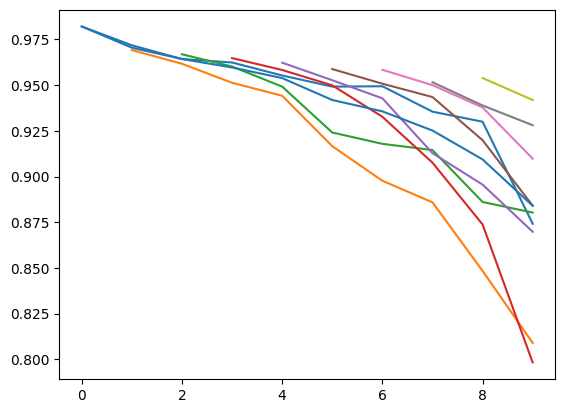

In [ ]:
permutedMNIST(100, 0, 'random', 0)

Task 1


Epochs: 100%|██████████| 100/100 [00:02<00:00, 47.42it/s, Loss: 0.0950, Acc: 0.9800]


Loss = 0.05590676888823509, Accuracy: 0.9814
Loss = 0.05590676888823509, Accuracy: 0.9814
Task 2


Epochs: 100%|██████████| 100/100 [00:05<00:00, 19.47it/s, Loss: 0.1123, Acc: 0.9575]


Loss = 0.06470521539449692, Accuracy: 0.9745, Loss = 0.06806813180446625, Accuracy: 0.9713
Loss = 0.06638667359948158, Accuracy: 0.9729
Task 3


Epochs: 100%|██████████| 100/100 [00:06<00:00, 15.18it/s, Loss: 0.1825, Acc: 0.9517]


Loss = 0.07044484466314316, Accuracy: 0.9695, Loss = 0.07761819660663605, Accuracy: 0.9631, Loss = 0.07110714912414551, Accuracy: 0.9683
Loss = 0.07305673013130824, Accuracy: 0.9669666666666666
Task 4


Epochs: 100%|██████████| 100/100 [00:08<00:00, 11.12it/s, Loss: 0.2193, Acc: 0.9463]


Loss = 0.07493063807487488, Accuracy: 0.966, Loss = 0.08408962935209274, Accuracy: 0.9544, Loss = 0.07539162039756775, Accuracy: 0.965, Loss = 0.0745856985449791, Accuracy: 0.9661
Loss = 0.07724939659237862, Accuracy: 0.962875
Task 5


Epochs: 100%|██████████| 100/100 [00:11<00:00,  8.54it/s, Loss: 0.1431, Acc: 0.9400]


Loss = 0.08271373808383942, Accuracy: 0.9575, Loss = 0.09386386722326279, Accuracy: 0.9452, Loss = 0.08953330665826797, Accuracy: 0.9489, Loss = 0.0788588747382164, Accuracy: 0.9612, Loss = 0.07572025805711746, Accuracy: 0.9639
Loss = 0.08413800895214081, Accuracy: 0.95534
Task 6


Epochs: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s, Loss: 0.2178, Acc: 0.9200]


Loss = 0.08766691386699677, Accuracy: 0.9521, Loss = 0.10242191702127457, Accuracy: 0.934, Loss = 0.09775351732969284, Accuracy: 0.942, Loss = 0.08484561741352081, Accuracy: 0.9522, Loss = 0.08325423300266266, Accuracy: 0.9556, Loss = 0.0764412060379982, Accuracy: 0.9639
Loss = 0.08873056744535764, Accuracy: 0.9499666666666666
Task 7


Epochs: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s, Loss: 0.3425, Acc: 0.9150]


Loss = 0.09443281590938568, Accuracy: 0.9444, Loss = 0.10620824247598648, Accuracy: 0.9274, Loss = 0.09962982684373856, Accuracy: 0.9443, Loss = 0.08775502443313599, Accuracy: 0.9495, Loss = 0.08973819017410278, Accuracy: 0.9511, Loss = 0.08333463221788406, Accuracy: 0.9571, Loss = 0.07848433405160904, Accuracy: 0.9609
Loss = 0.09136900944369179, Accuracy: 0.9478142857142857
Task 8


Epochs: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s, Loss: 0.3808, Acc: 0.8806]


Loss = 0.09727679193019867, Accuracy: 0.94, Loss = 0.10917039960622787, Accuracy: 0.9241, Loss = 0.1021503135561943, Accuracy: 0.941, Loss = 0.09890156984329224, Accuracy: 0.934, Loss = 0.10522761940956116, Accuracy: 0.9301, Loss = 0.09959201514720917, Accuracy: 0.9417, Loss = 0.08789277821779251, Accuracy: 0.9487, Loss = 0.08212148398160934, Accuracy: 0.9551
Loss = 0.09779162146151066, Accuracy: 0.9393375
Task 9


Epochs: 100%|██████████| 100/100 [00:21<00:00,  4.60it/s, Loss: 0.4061, Acc: 0.8828]


Loss = 0.10401123762130737, Accuracy: 0.9323, Loss = 0.12353076785802841, Accuracy: 0.8985, Loss = 0.11481155455112457, Accuracy: 0.9185, Loss = 0.10909024626016617, Accuracy: 0.9228, Loss = 0.12312572449445724, Accuracy: 0.9013, Loss = 0.11008577048778534, Accuracy: 0.9247, Loss = 0.09511836618185043, Accuracy: 0.9408, Loss = 0.08683973550796509, Accuracy: 0.951, Loss = 0.08588863909244537, Accuracy: 0.9503
Loss = 0.10583356022834778, Accuracy: 0.9266888888888889
Task 10


Epochs: 100%|██████████| 100/100 [00:24<00:00,  4.06it/s, Loss: 0.4691, Acc: 0.8795]


Loss = 0.10830841958522797, Accuracy: 0.9237, Loss = 0.14101946353912354, Accuracy: 0.8664, Loss = 0.13130569458007812, Accuracy: 0.8891, Loss = 0.12274353951215744, Accuracy: 0.8985, Loss = 0.1227474957704544, Accuracy: 0.9007, Loss = 0.11165481805801392, Accuracy: 0.9221, Loss = 0.10199841856956482, Accuracy: 0.9327, Loss = 0.1000455766916275, Accuracy: 0.934, Loss = 0.09537293016910553, Accuracy: 0.9398, Loss = 0.08697199076414108, Accuracy: 0.95
Loss = 0.11221683472394943, Accuracy: 0.9157
[{0: [0.9814, 0.05590676888823509], 'all': [0.9814, 0.05590676888823509]}, {0: [0.9745, 0.06470521539449692], 1: [0.9713, 0.06806813180446625], 'all': [0.9729, 0.06638667359948158]}, {0: [0.9695, 0.07044484466314316], 1: [0.9631, 0.07761819660663605], 2: [0.9683, 0.07110714912414551], 'all': [0.9669666666666666, 0.07305673013130824]}, {0: [0.966, 0.07493063807487488], 1: [0.9544, 0.08408962935209274], 2: [0.965, 0.07539162039756775], 3: [0.9661, 0.0745856985449791], 'all': [0.962875, 0.0772493965

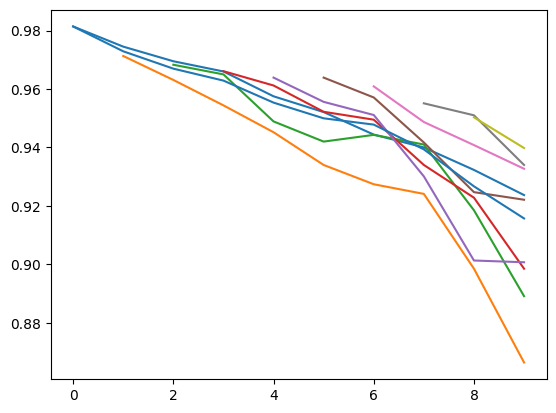

In [ ]:
permutedMNIST(100, 200, 'random', 0)

Task 1


Epochs: 100%|██████████| 100/100 [00:02<00:00, 41.64it/s, Loss: 0.5250, Acc: 0.8850]


Loss = 0.05543075501918793, Accuracy: 0.9821
Loss = 0.05543075501918793, Accuracy: 0.9821
Task 2


Epochs: 100%|██████████| 100/100 [00:05<00:00, 19.04it/s, Loss: 0.7348, Acc: 0.8600]


Loss = 0.06399618834257126, Accuracy: 0.9766, Loss = 0.06849180161952972, Accuracy: 0.9734
Loss = 0.06624399498105049, Accuracy: 0.975
Task 3


Epochs: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s, Loss: 0.7881, Acc: 0.7917]


Loss = 0.07413611561059952, Accuracy: 0.9683, Loss = 0.07419440895318985, Accuracy: 0.9666, Loss = 0.0721282884478569, Accuracy: 0.9681
Loss = 0.0734862710038821, Accuracy: 0.9676666666666667
Task 4


Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s, Loss: 0.8111, Acc: 0.7975]


Loss = 0.08411097526550293, Accuracy: 0.9576, Loss = 0.08097007870674133, Accuracy: 0.9585, Loss = 0.07877115160226822, Accuracy: 0.961, Loss = 0.07719065248966217, Accuracy: 0.9625
Loss = 0.08026071451604366, Accuracy: 0.9599
Task 5


Epochs: 100%|██████████| 100/100 [00:11<00:00,  8.43it/s, Loss: 0.9545, Acc: 0.7700]


Loss = 0.09659487754106522, Accuracy: 0.9424, Loss = 0.0914892628788948, Accuracy: 0.946, Loss = 0.08350446820259094, Accuracy: 0.9573, Loss = 0.08593446761369705, Accuracy: 0.9532, Loss = 0.077777199447155, Accuracy: 0.9607
Loss = 0.08706005513668061, Accuracy: 0.95192
Task 6


Epochs: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s, Loss: 0.9827, Acc: 0.7583]


Loss = 0.10935235023498535, Accuracy: 0.9234, Loss = 0.10126305371522903, Accuracy: 0.9343, Loss = 0.09792983531951904, Accuracy: 0.9413, Loss = 0.10198476910591125, Accuracy: 0.9305, Loss = 0.08310345560312271, Accuracy: 0.9562, Loss = 0.08206450939178467, Accuracy: 0.9561
Loss = 0.09594966222842534, Accuracy: 0.9403
Task 7


Epochs: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s, Loss: 1.3503, Acc: 0.7314]


Loss = 0.12255693972110748, Accuracy: 0.8968, Loss = 0.1116466298699379, Accuracy: 0.9204, Loss = 0.10670958459377289, Accuracy: 0.932, Loss = 0.11613727360963821, Accuracy: 0.9098, Loss = 0.09544701874256134, Accuracy: 0.9455, Loss = 0.08705359697341919, Accuracy: 0.9507, Loss = 0.08298079669475555, Accuracy: 0.9554
Loss = 0.10321883431502751, Accuracy: 0.9300857142857143
Task 8


Epochs: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s, Loss: 1.8518, Acc: 0.7100]


Loss = 0.13531729578971863, Accuracy: 0.8722, Loss = 0.11939378082752228, Accuracy: 0.9065, Loss = 0.10842439532279968, Accuracy: 0.9306, Loss = 0.12649691104888916, Accuracy: 0.9026, Loss = 0.11424951255321503, Accuracy: 0.9323, Loss = 0.0927741676568985, Accuracy: 0.9421, Loss = 0.0969662219285965, Accuracy: 0.9412, Loss = 0.08560919016599655, Accuracy: 0.953
Loss = 0.10990393441170454, Accuracy: 0.9225625
Task 9


Epochs: 100%|██████████| 100/100 [00:21<00:00,  4.58it/s, Loss: 1.4243, Acc: 0.6928]


Loss = 0.1344338208436966, Accuracy: 0.8764, Loss = 0.1234801709651947, Accuracy: 0.8992, Loss = 0.11528269201517105, Accuracy: 0.9186, Loss = 0.1298287808895111, Accuracy: 0.8973, Loss = 0.1267637461423874, Accuracy: 0.9107, Loss = 0.10371491312980652, Accuracy: 0.9274, Loss = 0.10701418668031693, Accuracy: 0.9275, Loss = 0.09121105074882507, Accuracy: 0.9459, Loss = 0.0885511264204979, Accuracy: 0.9498
Loss = 0.11336449864837858, Accuracy: 0.9169777777777778
Task 10


Epochs: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s, Loss: 1.7669, Acc: 0.6765]


Loss = 0.1404535323381424, Accuracy: 0.865, Loss = 0.13135254383087158, Accuracy: 0.8859, Loss = 0.12460267543792725, Accuracy: 0.9044, Loss = 0.14256328344345093, Accuracy: 0.8738, Loss = 0.1315474957227707, Accuracy: 0.8991, Loss = 0.11313048750162125, Accuracy: 0.912, Loss = 0.11503716558218002, Accuracy: 0.9183, Loss = 0.09562433511018753, Accuracy: 0.9419, Loss = 0.09260730445384979, Accuracy: 0.9447, Loss = 0.08913347870111465, Accuracy: 0.9473
Loss = 0.11760523021221161, Accuracy: 0.90924
[{0: [0.9821, 0.05543075501918793], 'all': [0.9821, 0.05543075501918793]}, {0: [0.9766, 0.06399618834257126], 1: [0.9734, 0.06849180161952972], 'all': [0.975, 0.06624399498105049]}, {0: [0.9683, 0.07413611561059952], 1: [0.9666, 0.07419440895318985], 2: [0.9681, 0.0721282884478569], 'all': [0.9676666666666667, 0.0734862710038821]}, {0: [0.9576, 0.08411097526550293], 1: [0.9585, 0.08097007870674133], 2: [0.961, 0.07877115160226822], 3: [0.9625, 0.07719065248966217], 'all': [0.9599, 0.08026071451

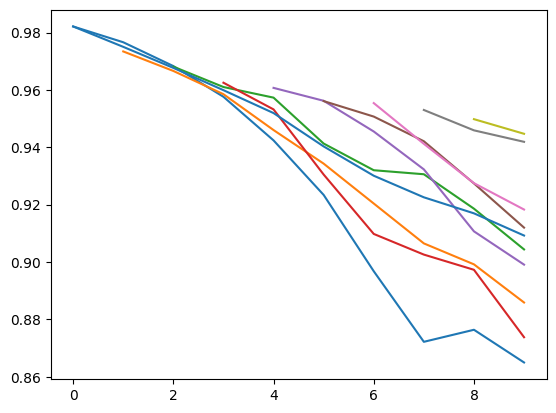

In [ ]:
permutedMNIST(100, 200, 'centre', 0)

In [ ]:
permutedMNIST(100, 0, 'random', 1)

In [ ]:
permutedMNIST(100, 200, 'random', 1)

In [ ]:
permutedMNIST(100, 200, 'centre', 1)

# Split MNIST

In [ ]:
splitMNIST(120, 0, 'random', 0)

Task 1


Epochs:   4%|▍         | 5/120 [00:05<01:57,  1.02s/it, Loss: 50.1886, Acc: 1.0000]


KeyboardInterrupt: 

In [ ]:
splitMNIST(120, 40, 'random', 0)

In [ ]:
splitMNIST(120, 40, 'centre', 0)

In [ ]:
splitMNIST(120, 0, 'random', 1)

In [ ]:
splitMNIST(120, 40, 'random', 1)

In [ ]:
splitMNIST(120, 40, 'centre', 1)

# Split notMNIST

In [ ]:
splitnotMNIST(120, 0, 'random', 0)

In [ ]:
splitnotMNIST(120, 40, 'random', 0)

In [ ]:
splitnotMNIST(120, 40, 'centre', 0)

In [ ]:
splitnotMNIST(120, 0, 'random', 1)

In [ ]:
splitnotMNIST(120, 40, 'random', 1)

In [ ]:
splitnotMNIST(120, 40, 'centre', 1)